#### Load .db

In [2]:
from pathlib import Path
import os, sqlite3, pandas as pd
import matplotlib.pyplot as plt

# find repo root (folder with .git)
p = Path(os.getcwd())
while p != p.parent and not (p/".git").exists():
    p = p.parent
ROOT = p
DB = ROOT / "events.db"

print("Using DB:", DB.resolve())

# open read-only (prevents accidentally creating an empty DB)
con = sqlite3.connect(f"file:{DB.resolve()}?mode=ro", uri=True)

Using DB: /Users/student/Desktop/NWU_MLDS/400/final/ticketmaster-data-collection/events.db


In [3]:
# tables
tables = pd.read_sql("""
    SELECT name, type
    FROM sqlite_master
    WHERE type IN ('table','view')
    ORDER BY type, name;
""", con)
tables

,name,type
0,artists,table
1,event_price_history,table
2,events,table
3,venues,table


In [4]:
# row counts
row_counts = []
for t in tables[tables.type=="table"]["name"]:
    n = pd.read_sql(f"SELECT COUNT(*) AS n FROM {t};", con).iloc[0,0]
    row_counts.append({"table": t, "rows": n})
pd.DataFrame(row_counts)

,table,rows
0,artists,2219
1,event_price_history,10157
2,events,4410
3,venues,1783


#### Table Overview

In [5]:
pd.read_sql("PRAGMA table_info(events);", con)

,cid,name,type,notnull,dflt_value,pk
0,0,event_id,TEXT,0,None,1
1,1,name,TEXT,0,None,0
2,2,url,TEXT,0,None,0
3,3,type,TEXT,0,None,0
4,4,locale,TEXT,0,None,0
5,5,status,TEXT,0,None,0
6,6,datetime,TIMESTAMP,0,None,0
7,7,onsale_date,TIMESTAMP,0,None,0
8,8,offsale_date,TIMESTAMP,0,None,0
9,9,segment,TEXT,0,None,0


In [6]:
pd.read_sql("PRAGMA table_info(artists);", con)

,cid,name,type,notnull,dflt_value,pk
0,0,artist_id,TEXT,0,None,1
1,1,artist_name,TEXT,0,None,0


In [7]:
pd.read_sql("PRAGMA table_info(event_price_history);", con)

,cid,name,type,notnull,dflt_value,pk
0,0,event_id,TEXT,1,None,1
1,1,snapshot_date,TIMESTAMP,1,None,2
2,2,min_price,REAL,0,None,0
3,3,max_price,REAL,0,None,0
4,4,currency,TEXT,0,None,0


In [8]:
pd.read_sql("PRAGMA table_info(venues);", con)

,cid,name,type,notnull,dflt_value,pk
0,0,venue_id,TEXT,0,None,1
1,1,venue_name,TEXT,0,None,0
2,2,city,TEXT,0,None,0
3,3,state,TEXT,0,None,0
4,4,country,TEXT,0,None,0
5,5,lat,REAL,0,None,0
6,6,lon,REAL,0,None,0


Events by scheduled date

Text(0.5, 0, 'month')

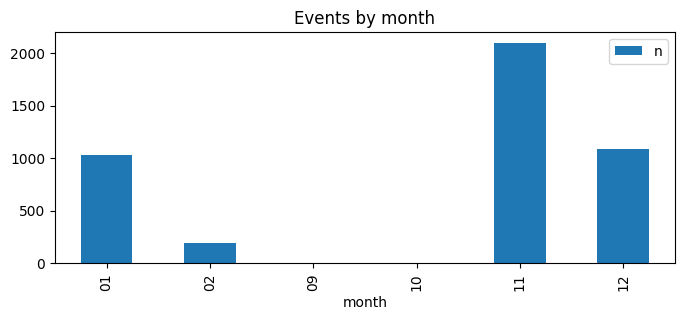

In [9]:
by_month = pd.read_sql("""
    SELECT strftime('%m', datetime) AS month, COUNT(*) AS n
    FROM (SELECT DISTINCT event_id, datetime FROM events WHERE datetime IS NOT NULL)
    GROUP BY month 
    ORDER BY month;
""", con)
ax = by_month.plot(x="month", y="n", kind="bar", figsize=(8,3), title="Events by month"); ax.set_xlabel("month")

<Axes: title={'center': 'Events by weekday'}, xlabel='weekday'>

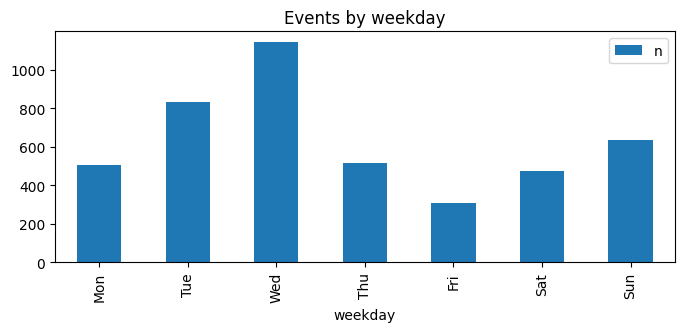

In [10]:
by_weekday = pd.read_sql("""
WITH u AS (SELECT DISTINCT event_id, datetime FROM events WHERE datetime IS NOT NULL)
SELECT
  CASE CAST(strftime('%w', datetime) AS INTEGER)
    WHEN 0 THEN 'Sun' WHEN 1 THEN 'Mon' WHEN 2 THEN 'Tue'
    WHEN 3 THEN 'Wed' WHEN 4 THEN 'Thu' WHEN 5 THEN 'Fri' ELSE 'Sat' END AS weekday,
  COUNT(*) AS n
FROM u
GROUP BY weekday
ORDER BY CASE weekday
  WHEN 'Mon' THEN 1 WHEN 'Tue' THEN 2 WHEN 'Wed' THEN 3
  WHEN 'Thu' THEN 4 WHEN 'Fri' THEN 5 WHEN 'Sat' THEN 6 ELSE 7
END;
""", con)

by_weekday.plot(x="weekday", y="n", kind="bar", figsize=(8,3), title="Events by weekday")

Cheapest price per event (ignore timing)

What is the lowest price we ever saw for each event?

,currency,rows
0,(NULL),8279
1,USD,1755
2,CAD,123


Text(0, 0.5, 'rows')

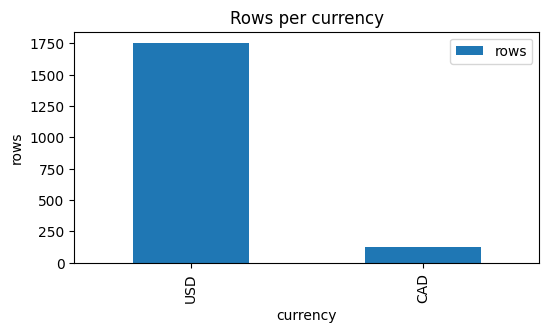

In [11]:
# distinct currencies and their counts
cur_counts = pd.read_sql("""
    SELECT COALESCE(currency,'(NULL)') AS currency, COUNT(*) AS rows
    FROM event_price_history
    GROUP BY currency
    ORDER BY rows DESC;
""", con)
display(cur_counts)

# quick bar chart
ax = cur_counts[cur_counts.currency!='(NULL)'] \
        .plot(x="currency", y="rows", kind="bar", figsize=(6,3),
              title="Rows per currency")
ax.set_xlabel("currency"); ax.set_ylabel("rows")

In [12]:
min_price_USD = pd.read_sql("""
    SELECT event_id, MIN(min_price) AS cheapest_price
    FROM event_price_history
    WHERE min_price IS NOT NULL AND currency = "USD"
    GROUP BY event_id;
""", con)
min_price_USD

,event_id,cheapest_price
0,rZ7HnEZ1AK--Z0,25.97
1,rZ7HnEZ1AK-3P7,21.57
2,rZ7HnEZ1AK-4FV,43.28
3,rZ7HnEZ1AK-Aq0,15.33
4,rZ7HnEZ1AK-EZV,100.31
...,...,...
762,rZ7HnEZ1AfupAN,24.94
763,rZ7HnEZ1AfupaK,24.94
764,rZ7HnEZ1AfuvuS,43.75
765,rZ7HnEZ1AfvOPN,0.00


When did that cheapest price occur? (event-centric timing)

How many days before the event did the cheapest price happen?

Text(0.5, 0, 'days before event (0 = event day)')

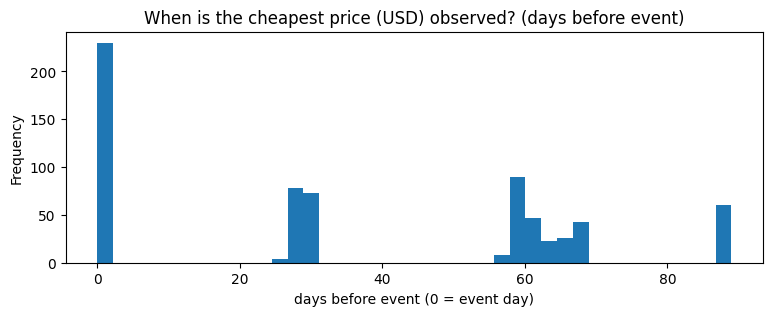

In [13]:
q = """
WITH ph AS (
  SELECT e.event_id, e.datetime AS event_dt,
         eph.snapshot_date, eph.min_price
  FROM events e
  JOIN event_price_history eph USING(event_id)
  WHERE e.datetime IS NOT NULL 
        AND eph.snapshot_date IS NOT NULL
        AND eph.min_price IS NOT NULL
        AND eph.currency = "USD"
        AND eph.snapshot_date <= e.datetime
),
ranked AS (
  SELECT ph.*,
         ROW_NUMBER() OVER (PARTITION BY event_id
                            ORDER BY min_price ASC, snapshot_date ASC) AS rnk
  FROM ph
)
SELECT event_id, event_dt, snapshot_date AS cheapest_on,
       min_price AS cheapest_price,
       CAST(julianday(event_dt) - julianday(snapshot_date) AS INTEGER) AS days_before_event
FROM ranked
WHERE rnk = 1;
"""
cheapest = pd.read_sql(q, con, parse_dates=["event_dt","cheapest_on"])

ax = cheapest.days_before_event.clip(0,180).plot(
    kind="hist", bins=40, figsize=(9,3),
    title="When is the cheapest price (USD) observed? (days before event)")
ax.set_xlabel("days before event (0 = event day)")

In [14]:
cheapest

,event_id,event_dt,cheapest_on,cheapest_price,days_before_event
0,rZ7HnEZ1AK--Z0,2025-11-30 16:00:00,2025-11-03,25.97,27
1,rZ7HnEZ1AK-3P7,2025-11-05 19:00:00,2025-11-04,21.57,1
2,rZ7HnEZ1AK-4FV,2025-11-30 20:00:00,2025-11-03,43.28,27
3,rZ7HnEZ1AK-Aq0,2025-11-30 19:00:00,2025-11-03,15.33,27
4,rZ7HnEZ1AK-EZV,2025-12-31 19:00:00,2025-11-03,100.31,58
...,...,...,...,...,...
677,rZ7HnEZ1AfuNCK,2025-11-30 19:00:00,2025-11-03,45.75,27
678,rZ7HnEZ1AfuNfd,2025-11-04 19:00:00,2025-11-03,24.36,1
679,rZ7HnEZ1Afug3K,2025-11-04 19:30:00,2025-11-03,63.95,1
680,rZ7HnEZ1AfupAN,2025-11-30 22:30:00,2025-11-03,24.94,27
